# Perceptron

Here we explain the fundamental mechanism of discrete backpropagation on the following introductory machine learning model: the binarized perceptron or nonlinear regression. Before we begin, we must explain some fundamental concepts:

**Definition 1** - A matrix is said to be binarized if it only takes entries in $\{-1,+1\}$.

**Definition 2** - The Hamming Distance denoted $d$ of two binarized matrices $A$ and $B$ of equal size is given by: $$d(A,B)=\dfrac12\sum_{i} A_i + B_i$$

or in plain english "*the number of entries that are different between the two matrices*".

**Definition 3** - We typically denote a sample-wise ground truth $z$ and an input $x$ and batched ground truth $Z$ and an input $X$.

**Definition 4** - Given a binarized ground truth $Z$ and an input $X$, a binarized perceptron aims to find a binarized matrix $W$ and an integer vector $b$ to compute $\hat{Z}$ via:

$$\hat{Z} = \text{sign}(XW - b)$$

Where $\text{sign}$ is given by:

$$\text{sign}(x)=\begin{cases}-1\qquad \text{if }x<0\\ +1\qquad \text{if }x\geq 0 \end{cases}$$

Such that, $d(Z,\hat{Z})$ is minimized by correct choice of $W$ and $b$.

**Note 1** the matrix multiplication is taken to be ordinary matrix multiplication as one would do on integer matrices, if we map $-1\to 0$ and $+1\to 1$ in typical binary fashion - we replace the multiplication in the individual dot products with an bitwise XNOR and addition is then taken to be a population count/*Hamming weight* of the bit-string left after this XNOR'ing.

**Note 2** In practice, transistor-for-transistor *XOR* gates are simpler to implement and indeed in the experimental binary warp-level matrix multiply and accumulate instructions available on post-Turing Nvidia GPUs this is what actually gets used - and similarly in FPGA - however, the underlying mathematics of perceptron changes little and we can still train successfully in this regime.

This has problem has already been solved in various ways using either PlumerAi's Latent-Free approach or Bengio-et-al's Latent approach. In this notebook, I identify and explain a new approach which builds on PlumerAi's Latent-Free approach that I call "discrete optimization".

### Discrete Optimization

Discrete Optimization works on the following simple observation: that in the dot product of two binarized vectors, that the individual entries of both vectors can only work to either increment or decrement the final dot product.

This obvious fact, can be applied to find an optimization signal for the Perceptron. To simplify matters we'll first consider the case of a single sample $x$ and a single ground truth label $z$, for both we'll assume size 10. $\hat{z}$ is produced by the Perceptron formula and we can compare this against $z$.

```
z_hat = -1 +1 -1 -1 +1 -1 -1 -1 -1 -1 -1 -1
z     = -1 +1 -1 -1 -1 +1 -1 -1 -1 -1 -1 -1 
```

Here we have a few different kinds of behaviors which encode various signals:

1. Predicted: -1/+1, Truth: -1/+1 respectively, correct prediction - nothing to optimize here
2. Predicted: -1, Truth: +1, false negative - dot product between input $x$ and corresponding column in $W$ minus bias term $b$ was too **small**!
3. Predicted: +1, Truth: -1, false positive - dot product between input $x$ and corresponding column in $W$ minus bias term $b$ was too **big**!

We have a clear optimization signal here, we have to either increase or decrease the size of the value before we take its *sign*, we have two possible solutions:

1. The easiest is that we can simply increase/decrease the size of the bias to limit the effect of the dot product, in which ever way prevents the problem (too big vs too small)
2. Harder, is that we can look at the individual multiplications in the dot product and figure out which values in the $W$ column are contributing to this mess.

We call this process "blame attribution", where we figure out exactly which values we can blame for mispredictions. We cover the process of blame attribution for both the false positive and false negative case:

- False Positive:

Continuing our example, a false positive occurs at the $5^{\text{th}}$ entry of the $z/\hat{z}$ pair. This means that the dot product of $5^{\text{th}}$ column of $W$, denoted $W_5$ and $x$ exceeds that bias term $b_5$ - we can blame $b_5$ for being too small and attribute blame for it to increase in size. We can take a closer look at the values of $W_5$ and $x$ and attribute blame to the individual weights of this dot product:

```
W_5 = -1 +1 +1 -1 +1 +1 -1 +1 -1 +1
x   = -1 +1 -1 +1 -1 +1 -1 +1 -1 +1
```

$W_5$ can blamed for this unusual result in all of its entries except entries 3,4,5. So we attribute blame accordingly to these entries.

- False Negative:

In our example, the false negative occurs at the $6^{\text{th}}$ entry of the $z/\hat{z}$ pair. So we blame the bias term $b_6$ for being too large, and examine the dot product to $W_6$ as we did above to attribute blame:

```
W_6 = +1 -1 +1 +1 -1 +1 +1 -1 +1 -1 
x   = -1 +1 -1 +1 -1 +1 -1 +1 -1 +1
```

And now it is entries 4, 5, 6 that can be blamed for this false negative.

### Keeping Score

Now that we have our basic optimization signals, we can start tallying them, much in the same way as Plumerai's BOP tallies evidence determined from backpropagation. As a reminder, each weight is expected to have an unsigned blame counter that keeps track of the blame attributed to it as the network cycles through tasks, and similarly each bias term, however - this blame counter in this case is signed.

Once the blame counted, passes a certain threshold, either the weight is flipped or the bias is increment/decrement (dependent on sign). Most importantly, the process must also forgive blame by periodically incrementing/decrementing all counters towards 0 - this has the desired effect of removing erroneous blame that is attributed either as a result of noise in the data or from historical behaviour as the Perceptron is tuned.

With all of this, we are now ready to implement a binarized Perceptron.

### Implementation

We will train the binarized perceptron on the famous `MNIST` dataset, below we are given a simple viewer which shows how individual samples of the MNIST dataset are thresholded into a binarized from that we can work with.

2022-11-12 23:20:49.540999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-12 23:20:49.715584: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-12 23:20:50.761889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-12 23:20:50.761961: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

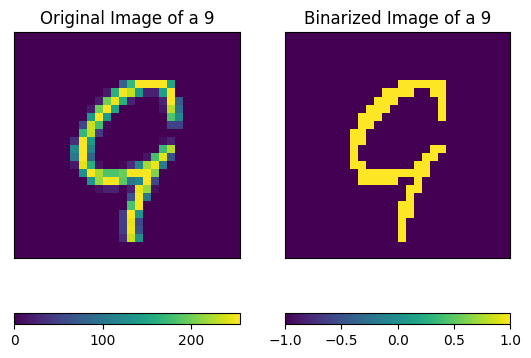

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Pretty MNIST rendering
fig, axs = plt.subplots(1,2)

IMAGE_TO_PREVIEW = 782
THRESHOLD = 128

original = axs[0].imshow(x_train[IMAGE_TO_PREVIEW].reshape(28,28))
binarized = axs[1].imshow((x_train[IMAGE_TO_PREVIEW].reshape(28,28) > THRESHOLD)*2-1)

plt.colorbar(original,orientation='horizontal')
plt.colorbar(binarized,orientation='horizontal')

axs[0].set_title("Original Image of a "+str(y_train[IMAGE_TO_PREVIEW]))
axs[1].set_title("Binarized Image of a "+str(y_train[IMAGE_TO_PREVIEW]))
axs[0].tick_params(axis='both',bottom=False,labelbottom=False,left=False,labelleft=False)
axs[1].tick_params(axis='both',bottom=False,labelbottom=False,left=False,labelleft=False)

# Full data conversion
x_train = ((x_train > THRESHOLD)*2 - 1).reshape(x_train.shape[0],28*28)
x_test = ((x_test > THRESHOLD)*2 - 1).reshape(x_test.shape[0],28*28)
y_train = tf.one_hot(y_train,depth=10)*2 - 1
y_test = tf.one_hot(y_test,depth=10)*2 - 1

# Render pretty MNIST render
plt.show()

With the data correctly loaded, we can begin by initializing the Perceptron itself, we will do this by

- Initializing $W$ to be a random binarized matrix of size 784-by-10
- Initializing $b$ to be a random integer matrix of size 10 with entries between 0 and 784
- Initializing all blame counters for both $W$ and $b$ and define increment/flipping thresholds
- Initialize counter and define time at which to decrement counter (this is usually the average expected time of two samples of the same class)

In particular, we'd like to emphasize that the blame counters can be especially small - that is, only 4-8 bits are required for blame attribution, as opposed to the full floating point number required in Plumerai's Latent-Free approach. This makes our training requirements very small.

Training in general is much more sensitive to the counter decay rate than anything else.

In [2]:
import numpy as np

# Set seed for reproducability
SEED = 1337
np.random.seed(SEED)

# Define random W and b
W = (np.random.uniform(0,1,(784,10)) < 0.5)*2 - 1
b = np.random.randint(0,784,10)

# Create blame attribution counters
W_blame = np.zeros((784,10))
b_blame = np.zeros(10)

# Define the requisite thresholds
W_THRES = 16
b_THRES = 4

# Counters and counter logic
counter = 0
counter_RESET = 10

W.shape, b.shape

((784, 10), (10,))

We can finally define some functions to provide a method to process data-samples and train the perceptron.

In [3]:
# Feedforward one sample
def forward(W,b,x):
    out = np.sign(x@W-b)
    out[out == 0] = 1
    return out

# Discover which columns/bias terms are to blame
def blame_columns(z,zhat):

    # Binarize inputs
    z = z > 0
    zhat = zhat > 0

    # Compute where there are false positives and false negatives
    false_pos = np.logical_and(zhat,np.logical_not(z))
    false_neg = np.logical_and(np.logical_not(zhat),z)

    # Increment bias blame for false positives (too big!)
    for idx, i in enumerate(false_pos):
        if i:
            b_blame[idx] += 1

    # Decrement bias blame for false negatives (too small!)
    for idx, i in enumerate(false_neg):
        if i:
            b_blame[idx] -= 1

    # If bias threshold is crossed, reset blame and increment/decrement bias
    for idx, i in enumerate(np.abs(b_blame)>b_THRES):
        if np.sign(b_blame[idx]) > 0 and i:
            b[idx] += 1
        elif np.sign(b_blame[idx]) < 0 and i:
            b[idx] -= 1

    return false_pos, false_neg

def blame_weights(x,false_pos,false_neg):

    # Binarize inputs
    x = x > 0

    # If a weight is found to be blame for a false positive attribute blame
    for idx, i in enumerate(false_pos):
        if i:
            for jdx, j in enumerate(np.logical_not(np.logical_xor(W[:,idx]>0,x))):
                if j:
                    W_blame[jdx,idx] += 1

    # If a weight is found to be blame for a false negative attribute blame
    for idx, i in enumerate(false_neg):
        if i:
            for jdx, j in enumerate(np.logical_xor(W[:,idx]>0,x)):
                if j:
                    W_blame[jdx,idx] += 1

    # Find where weights exceed the blame threshold
    rows,cols = np.where(W_blame >= W_THRES)

    # Reset blame counter and flip corresponding weight
    for i,j in zip(rows,cols):
        W_blame[i,j] = 0
        W[i,j] = W[i,j] * -1

With all functions defined, we are now able to run our perceptron and train it using discrete optimization.

In [7]:
from tqdm import tqdm


acc = 0
acc_count = 0
REPORT = 10000
epochs = 1

for e in range(epochs):
    print("EPOCH "+str(e+1))
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    for i in tqdm(indices):

        x = x_train[i]
        y = y_train[i]

        # Predict
        zhat = forward(W,b,x)

        # Attribute blame
        fp,fn = blame_columns(y,zhat)
        blame_weights(x,fp,fn)

        # "Forgiveness counter"
        counter += 1
        if counter >= counter_RESET:
            W_blame -= 1
            W_blame[W_blame < 0] = 0
            b_blame = np.sign(b_blame)*(np.abs(b_blame) - 1)
            counter = 0

        # Accuracy metric counter
        acc += np.sum(np.logical_and(zhat > 0, y > 0))
        acc_count += 1
        if acc_count >= REPORT:
            print("Current Accuracy: " + str(acc / REPORT))
            acc_count = 0
            acc = 0





EPOCH 1


 17%|█▋        | 10337/60000 [00:06<00:27, 1780.03it/s]

Current Accuracy: 0.6853


 34%|███▍      | 20309/60000 [00:11<00:21, 1809.39it/s]

Current Accuracy: 0.6847


 51%|█████     | 30318/60000 [00:17<00:16, 1806.44it/s]

Current Accuracy: 0.6973


 67%|██████▋   | 40274/60000 [00:23<00:11, 1723.29it/s]

Current Accuracy: 0.6843


 84%|████████▍ | 50264/60000 [00:29<00:05, 1636.06it/s]

Current Accuracy: 0.6935


 87%|████████▋ | 52021/60000 [00:30<00:04, 1688.18it/s]


KeyboardInterrupt: 

Awesome, so our model guesses labels correctly in 84% of cases, not bad for a silly counting system. As a great sanity test for perceptrons, we can see that the statistical forms of our various characters have embedded themselves into their corresponding layers - providing a clear insight into how the perceptron is operating:

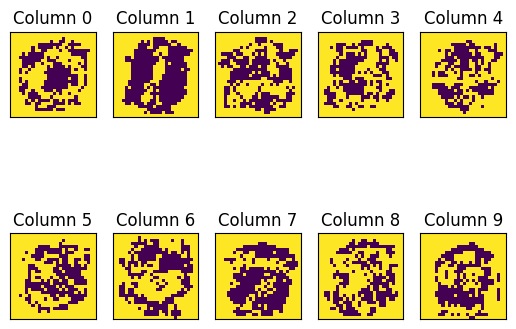

In [8]:
fig, axs = plt.subplots(2,5)

for i in range(10):
    axs[i//5,i%5].set_title("Column "+str(i))
    axs[i//5,i%5].imshow(W[:,i].reshape(28,28))
    axs[i//5,i%5].tick_params(axis='both',bottom=False,labelbottom=False,left=False,labelleft=False)
plt.show()

Finally, we shall test our trained network on the MNIST testing set to see how well our perceptron generalizes given lessons learnt.

In [9]:
acc = 0
acc_count = 0
REPORT = 10000

for x,y in tqdm(zip(x_test,y_test)):

    #Forward
    zhat = forward(W,b,x)

    # Accuracy metric counter
    acc += np.sum(np.logical_and(zhat > 0, y > 0))
    acc_count += 1
    if acc_count >= REPORT:
        print("Current Accuracy: " + str(acc / REPORT))
        acc_count = 0
        acc = 0

10000it [00:03, 2718.23it/s]

Current Accuracy: 0.6959
